# Introduction to Adversarial Attacks

In [1]:
import xlab
import torch

# 1. Loading our "Tiny" Wideresnet Model

To save you time, we have pretrained a model for CIFAR image classification. Our model scores ~83.86% on test CIFAR 10 test set. While this performance make appear to be somewhat low, it is actually a very good model for it's size. If you are interested in exploring this model more or improving it's performance, you can view our code [here](https://github.com/zroe1/xlab-ai-security/tree/main/models/adversarial_basics_cnn).

In [2]:
from huggingface_hub import hf_hub_download
from xlab.models import MiniWideResNet, BasicBlock

model_path = hf_hub_download(
    repo_id="uchicago-xlab-ai-security/tiny-wideresnet-cifar10",
    filename="adversarial_basics_cnn.pth"
)
model = torch.load(model_path, map_location='cpu', weights_only=False)
_ = model.eval()

# 2. Loading and Processing Images

In future notebooks, you will be loading the CIFAR 10 dataset directly and benchmarking attacks on several images for different classes. For this notebook, to keep things simple, you will attack a single image: a picture of one of our team members' cat (his name is Thunderpaws). In a practical real world setting, when you are trying to use a model to classify a new image that was not originally in the train or test datasets, you first have to do some preprocessing.

### Task 2
Write a function that converts 'cat.jpg' into a transformed pytorch tensor and resizes it to (32,32)


In [3]:
# run this cell to load the image
img = xlab.utils.load_sample_image('cat.jpg')

<details>
<summary>💡 <b>Hint for Task #2</b></summary>

In our solution we use:
```python 
Compose([Transform1, Transform2])
```

</details>


<details>
<summary>🔐 <b>Solution for Task #2</b></summary>

```python

def process_image(path):
    """
    Convert file path to scaled torch tensor
    
    Parameters:
    -----------
    path : str
        Filepath for image

    Returns:
    --------
    processedImg: Scaled and transformed image tensor
    
    """
    img = Image.open(path)
    transform = Compose([Resize((32,32)), ToTensor()])
    processedImg = transform(img)
    processedImg = processedImg.unsqueeze(0)
    return processedImg
```

</details>

In [4]:
from torchvision.io import read_image
from torchvision.transforms import Compose, Resize, ToTensor
from PIL import Image

def process_image(path):
    """
    Convert file path to scaled torch tensor
    
    Parameters:
    -----------
    path : str
        Filepath for image

    Returns:
    --------
    processedImg: Scaled and transformed image tensor
    
    """
    # img = Image.open(path)
    img = xlab.utils.load_sample_image(path)
    transform = Compose([Resize((32,32)), ToTensor()])
    processedImg = transform(img)
    processedImg = processedImg.unsqueeze(0)
    return processedImg

In [5]:
_ = xlab.tests.section1_1.task2(process_image)


Running tests for Section 2.4.2, Task 2...
🎉 All tests passed! (2/2)

Detailed output:
============================= test session starts ==============================
collecting ... collected 2 items

../xlab-python-package/xlab/tests/section1_1.py::TestTask2::test_valid_output PASSED [ 50%]
../xlab-python-package/xlab/tests/section1_1.py::TestTask2::test_correct_output PASSED [100%]

============================== 2 passed in 0.05s ===============================



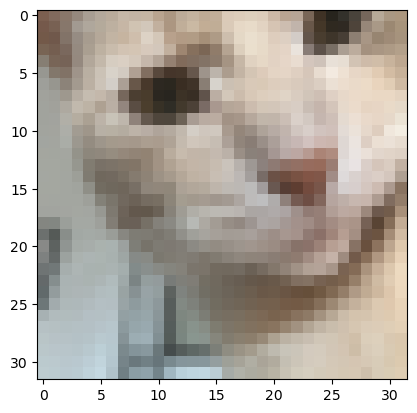

In [6]:
import matplotlib.pyplot as plt

def show_image(img):
    """
    Display image tensor using plt
    
    Parameters:
    -----------
    img : Tensor
        image Tensor to be displayed
    """
    img = img.squeeze(0)
    plt.imshow(img.permute(1, 2, 0).detach().numpy()) #Reorder columns as PIL and Torch order image data differently

show_image(process_image('cat.jpg'))

## 2a. Making Predictions

### Task 2a
Using the function you created above, predict what the model classifies the frog to be. The dataset we used to train the model is CIFAR 10, so the CNN will always produce one of the following categories:

<div align="center">
  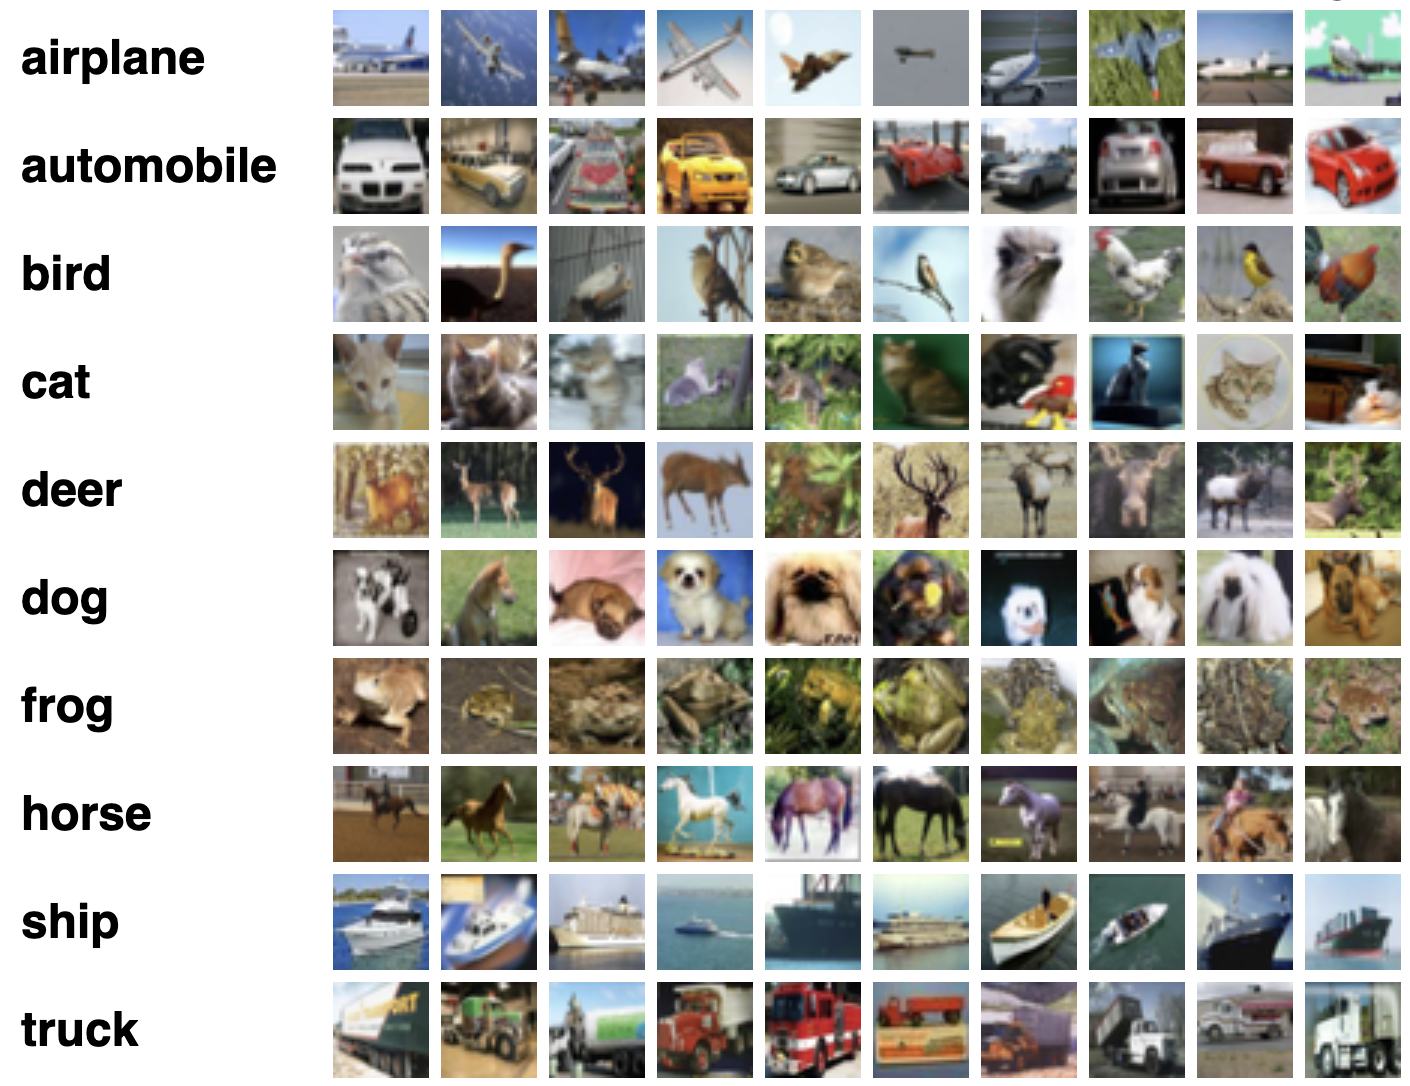
</div>

Check that you understand what the code below is doing. Then implement the missing code below to have the CNN predict a class for our frog image. If prediction leads to an error, the CNN was likely constructed incorrectly.


</details>

<details>
<summary>🔐 <b>Solution for Task #2a</b></summary>

```python

print(prediction(process_image('frog.jpg')))
```

</details>


In [7]:
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def prediction(img):
    """
    Return prediction tuple:
    
    Parameters:
    -----------
    model : PyTorch model used for classification
    img : Tensor
        image Tensor to be predicted

    Returns:
    --------
    pred_class : torch.Tensor
        The predicted class label
    prob : torch.Tensor
        The confidence of the model 
    
    """
    with torch.no_grad(): #Stops calculating gradients
        prediction = model(img)
        _, pred_class = torch.max(prediction, 1)
    probs = prediction.softmax(dim=-1) #Softmax function used to calculate probabilities
    return pred_class, probs[0][pred_class]


# Use the above functions to predict 'frog.jpg'
print(prediction(process_image('cat.jpg')))

(tensor([3]), tensor([0.9201]))


# 3. Making an adversarial image using FGSM
$ x' = x + \epsilon \cdot sign(\nabla loss_{F,t}(x))
$

### Task 3

The loss function, CrossEntropyLoss, has been loaded for you at the top of the cell below.

Using the above formula, complete the code for FGSM (Fast Gradient Sign Method). Work out the loss produced by the generated output with regard to the correct output (using loss_fn), and then calculate the gradient of this loss, relative to the input data. Find the signs of the gradient, and adjust x accordingly to complete the attack.

<details>
<summary>💡 <b>Hint for Task #3</b></summary>

The following python example demonstrates how to find the gradient of the loss function with respect to the pixels in the image:
```python

img.requires_grad = True
out = model(img)
loss = loss_fn(out, y)
loss.backward()
grad = img.grad.data

```

</details>


<details>

<summary>🔐 <b>Solution for Task #3</b></summary>

```python

def FGSM_generator(model, loss_fn, path, y, epsilon=8/255):
    """
    Create adversarial image with FGSM:
    
    Parameters:
    -----------
    model : PyTorch model used for classification
    loss_fn : Loss function
    path: Image filepath
    y: Image label
    epsilon: Perturbation variable

    Returns:
    --------
    adv_img: Adversarially perturbed image tensor
    """
    
    # 1. Calculate the loss
    img = process_image('frog.jpg')
    img.requires_grad = True
    out = model(img)
    loss = loss_fn(out, y)

    # 2. Calculate the gradient with respect to the input 
    loss.backward()
    grad = img.grad.data

    img.requires_grad_(False) # no longer need to track gradient

    # 3. Perturb the image using the signs of the gradient
    img_adv = img + epsilon * torch.sign(grad)

    #4. Clamp the image between 0 and 1
    img_adv = torch.clamp(img_adv, 0, 1)
    
    return img_adv
        
```

</details>

In [8]:
loss_fn = torch.nn.CrossEntropyLoss()

def FGSM_generator(model, loss_fn, path, y, epsilon=8/255):
    """
    Create adversarial image with FGSM:
    
    Parameters:
    -----------
    model : PyTorch model used for classification
    loss_fn : Loss function
    path: Image filepath
    y: Image label
    epsilon: Perturbation variable

    Returns:
    --------
    img_adv: Adversarially perturbed image tensor
    """

    # 1. Calculate the loss
    img = process_image(path)
    img.requires_grad = True
    out = model(img)
    print(out)
    loss = loss_fn(out, y)

    # 2. Calculate the gradient with respect to the input 
    loss.backward()
    grad = img.grad.data

    img.requires_grad_(False) # no longer need to track gradient

    # 3. Perturb the image using the signs of the gradient
    img_adv = img + epsilon * torch.sign(grad)

    #4. Clamp the image between 0 and 1
    img_adv = torch.clamp(img_adv, 0, 1)
    
    return img_adv

path = 'cat.jpg'
x_adv_FGSM = FGSM_generator(model, loss_fn, path, prediction(process_image(path))[0])
pred = prediction(x_adv_FGSM)
print(f"Prediction: {classes[pred[0]]} with probability {pred[1][0]:.2f}")

tensor([[-17.2021, -12.1075,  -6.7776,   3.6172, -12.8941,   1.1693, -11.4200,
          -4.4053, -16.3267, -19.8266]], grad_fn=<AddmmBackward0>)
Prediction: dog with probability 0.65


In [9]:
pred[0]

tensor([5])

In [10]:
_ = xlab.tests.section1_1.task3(model, FGSM_generator)


Running tests for Section 2.4.2, Task 3...
🎉 All tests passed! (4/4)

Detailed output:
============================= test session starts ==============================
collecting ... collected 4 items

../xlab-python-package/xlab/tests/section1_1.py::TestTask3::test_output_properties PASSED [ 25%]
../xlab-python-package/xlab/tests/section1_1.py::TestTask3::test_perturbation_is_applied PASSED [ 50%]
../xlab-python-package/xlab/tests/section1_1.py::TestTask3::test_epsilon_zero_produces_no_change PASSED [ 75%]
../xlab-python-package/xlab/tests/section1_1.py::TestTask3::test_output_adversarial PASSED [100%]

============================== 4 passed in 0.13s ===============================



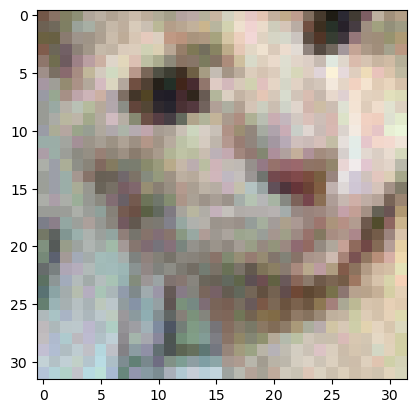

In [11]:
show_image(x_adv_FGSM)

# 4. Making an adversarial image using IGSM 


### Task 4

Now that you have completed the FGSM function, completing IGSM should be mostly the same. The one potentially challenging part is making sure that you are clipping the image in the correct way. That's why first we ask you complete the helper function for clipping before moving on to the full IGSM function. 

All this operation has to do is force x to be between x - ε and x + ε and between 0 and 1. You can use the [torch.clamp](https://docs.pytorch.org/docs/stable/generated/torch.clamp.html) function for this.

<details>
<summary>🔐 <b>Solution for Task #4</b></summary>

```python

def clip(x, x_original, epsilon):
    """
    Return clipped x
    
    Parameters:
    -----------
    x: Input image tensor
    epsilon: Perturbation variable
    
    Returns:
    --------
    x_clipped: Clipped version of image tensor x
    """
    
    diff = x - x_original
    
    # 1. Clip x epsilon distance away
    diff = torch.clamp(diff, -epsilon, epsilon)
    x_clipped = x_original + diff

    # 2. Clip x between 0 and 1
    x_final = torch.clamp(x_clipped, 0, 1)

    return x_final

```

</details>

In [12]:
from torch import clamp

def clip(x, x_original, epsilon):
    """
    Return clipped x
    
    Parameters:
    -----------
    x: Input image tensor
    epsilon: Perturbation variable
    
    Returns:
    --------
    x_clipped: Clipped version of image tensor x
    """
    
    ######### YOUR CODE STARTS HERE ######### 
    # 1. Clip x epsilon distance away
    # 2. Clip x between 0 and 1
    ########## YOUR CODE ENDS HERE ##########
    
    x_final = None

    diff = x - x_original
    
    # 1. Clip x epsilon distance away
    diff = torch.clamp(diff, -epsilon, epsilon)
    x_clipped = x_original + diff

    # 2. Clip x between 0 and 1
    x_final = torch.clamp(x_clipped, 0, 1)


    return x_final

In [13]:
_ = xlab.tests.section1_1.task4(clip)


Running tests for Section 2.4.2, Task 4...
🎉 All tests passed! (4/4)

Detailed output:
============================= test session starts ==============================
collecting ... collected 4 items

../xlab-python-package/xlab/tests/section1_1.py::TestTask4::test_clips_beyond_epsilon_ball PASSED [ 25%]
../xlab-python-package/xlab/tests/section1_1.py::TestTask4::test_clips_values_above_one PASSED [ 50%]
../xlab-python-package/xlab/tests/section1_1.py::TestTask4::test_clips_values_below_zero PASSED [ 75%]
../xlab-python-package/xlab/tests/section1_1.py::TestTask4::test_no_clipping_needed PASSED [100%]

============================== 4 passed in 0.02s ===============================



### Task 4a

$ x'_i = x'_{i-1} + clip_\epsilon(\alpha \cdot sign(\nabla loss_{F,t}(x'_{i-1})))
$

Using the above formula, complete the code for IGSM (Iterative Gradient Sign Method). You will not have to change much from your existing code for FGSM.

<details>
<summary>💡 <b>Hint for Task #4a</b></summary>


The PyTorch operations that you will need to use to do clipping and to update the image you are optimizing will throw errors for a tensor that requires grad. For example, you may see an error that looks something like this:

```
RuntimeError: a view of a leaf Variable that requires grad is being used in an in-place operation.
```

One way to work around this is to 'detach' the img tensor from the pytorch computational graph. In other words, this will remove gradient-tracking requirements and set `img.grad` to `None`.

```python
img = img.detach()
```


</details>



<details>
<summary>🔐 <b>Solution for Task #4a</b></summary>

```python

def IGSM_generator(model, loss_fn, path, y, epsilon=8/255, alpha=0.01, num_iters=6):
    """
    Create adversarial image with IGSM:
    
    Parameters:
    -----------
    model : PyTorch model used for classification
    loss_fn : Loss function
    path: Image filepath
    y: Image label
    epsilon: Perturbation variable
    Alpha: Perturbation variable
    num_iters: Number of iterations

    Returns:
    --------
    adv_img: Adversarially perturbed image tensor
    """
    
    img = process_image('frog.jpg')
    original_img = img.clone()

    # 1. loop num_iter times and complete 2-4 on each iteration
    for i in range(num_iters):
        img.requires_grad = True
        
        # 2. Calculate the loss
        out = model(img)
        loss = loss_fn(out, y)
    
        # 3. Calculate the gradient with respect to the input
        loss.backward()
        grad = img.grad.data
    
        # 4. Perturb the image using the signs of the gradient
        img.requires_grad_(False)
        img += alpha * torch.sign(grad)

        #5. Clamp the image within epsilon distance
        img = clip(img, original_img, epsilon)

    return img
```

</details>

In [14]:
def BIM_generator(model, loss_fn, path, y, epsilon=8/255, alpha=0.01, num_iters=6):
    """
    Create adversarial image with IGSM:
    
    Parameters:
    -----------
    model : PyTorch model used for classification
    loss_fn : Loss function
    path: Image filepath
    y: Image label
    epsilon: Perturbation variable
    Alpha: Perturbation variable
    num_iters: Number of iterations

    Returns:
    --------
    adv_img: Adversarially perturbed image tensor
    """
    img = process_image(path)
    original_img = img.clone()

    ######### YOUR CODE STARTS HERE ######### 
    # 1. loop num_iter times and complete 2-4 on each iteration
    # 2. Calculate the loss
    # 3. Calculate the gradient with respect to the input
    # 4. Perturb the image using the signs of the gradient
    #5. Clamp the image within epsilon distance
    ######### YOUR CODE ENDS HERE ######### 

    img = process_image(path)
    original_img = img.clone()

    # 1. loop num_iter times and complete 2-4 on each iteration
    for i in range(num_iters):
        img.requires_grad = True
        
        # 2. Calculate the loss
        out = model(img)
        loss = loss_fn(out, y)
    
        # 3. Calculate the gradient with respect to the input
        loss.backward()
        grad = img.grad.data
    
        # 4. Perturb the image using the signs of the gradient
        img.requires_grad_(False)
        img += alpha * torch.sign(grad)

        #5. Clamp the image within epsilon distance
        img = clip(img, original_img, epsilon)

    return img
    
path = 'cat.jpg'
x_adv_BIM = BIM_generator(model, loss_fn, path, prediction(process_image(path))[0])
pred = prediction(x_adv_BIM)
print(f"Prediction: {classes[pred[0]]} with probability {pred[1][0]:.2f}")
print(f"Max difference in pixels = {torch.max(torch.abs(x_adv_BIM - process_image('cat.jpg'))).item():.4f}")

Prediction: dog with probability 1.00
Max difference in pixels = 0.0314


In [15]:
_ = xlab.tests.section1_1.task4a(model, BIM_generator)


Running tests for Section 2.4.2, Task 4a...
🎉 All tests passed! (4/4)

Detailed output:
============================= test session starts ==============================
collecting ... collected 4 items

../xlab-python-package/xlab/tests/section1_1.py::TestTask4a::test_output_properties PASSED [ 25%]
../xlab-python-package/xlab/tests/section1_1.py::TestTask4a::test_perturbation_is_applied PASSED [ 50%]
../xlab-python-package/xlab/tests/section1_1.py::TestTask4a::test_epsilon_zero_produces_no_change PASSED [ 75%]
../xlab-python-package/xlab/tests/section1_1.py::TestTask4a::test_output_adversarial PASSED [100%]

============================== 4 passed in 0.28s ===============================



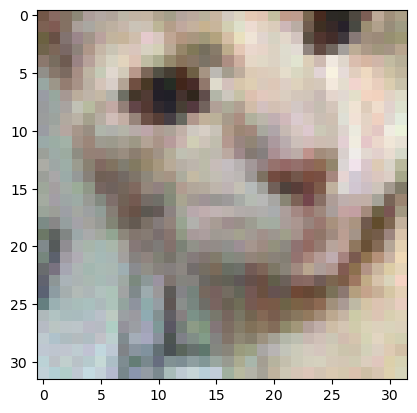

In [16]:
show_image(x_adv_BIM)

# 5. Making an adversarial image using PGD

PGD is almost identical to IGSM, with the only difference being 'random' intialization rather than zero.

### Task 5
Implement PGD. A helper function has been included to help do this. The 'clip' function you made above is also necessary.

<details>
<summary>🔐 <b>Solution for Task #5</b></summary>

```python
def PGD_generator(model, loss_fn, path, y, epsilon=8/255, alpha=0.01, num_iters=6):
    """
    Create adversarial image with PGD:
    
    Parameters:
    -----------
    model : PyTorch model used for classification
    loss_fn : Loss function
    path: Image filepath
    y: Image label
    epsilon: Perturbation variable
    Alpha: Perturbation variable
    num_iters: Number of iterations

    Returns:
    --------
    adv_img: Adversarially perturbed image tensor
    """

    # 1. add noise to initial image
    img = process_image('frog.jpg')
    original_img = img.clone()
    img = add_noise(img)
    
    # 2. loop num_iter times and complete 2-4 on each iteration
    for i in range(num_iters):
        img.requires_grad = True
        
        # 3. calculate the loss
        out = model(img)
        loss = loss_fn(out, y)
    
        # 4. calculate the gradient with respect to the input
        loss.backward()
        grad = img.grad.data
    
        # 5. perturb the image using the signs of the gradient
        img.requires_grad_(False)
        img += alpha * torch.sign(grad)
        img = clip(img, original_img, epsilon)

    return img
```

</details>

In [33]:
def add_noise(img, stdev=0.001, mean=0):
    """
    Helper function for PGD_generator
    
    Parameters:
    -----------
    img : Tensor
        image Tensor to be predicted

    Returns:
    --------
    noisy_img: Tensor
        Added noise to input
    """
    noise = torch.randn_like(img) * stdev + mean
    return img + noise

def PGD_generator(model, loss_fn, path, y, epsilon=8/255, alpha=0.01, num_iters=6):
    """
    Create adversarial image with PGD:
    
    Parameters:
    -----------
    model : PyTorch model used for classification
    loss_fn : Loss function
    path: Image filepath
    y: Image label
    epsilon: Perturbation variable
    Alpha: Perturbation variable
    num_iters: Number of iterations

    Returns:
    --------
    adv_img: Adversarially perturbed image tensor
    """
    
    ######### YOUR CODE STARTS HERE ######### 
    # 1. Add noise to initial image
    # 2. Loop num_iter times and complete 2-4 on each iteration
    # 3. Calculate the loss
    # 4. Calculate the gradient with respect to the input
    # 5. Perturb the image using the signs of the gradient
    ########## YOUR CODE ENDS HERE ########## 
    

    return img

path = 'frog.jpg'
x_adv_PGD = PGD_generator(model, loss_fn, path, prediction(process_image(path))[0])
pred = prediction(x_adv_PGD)
print(f"Prediction: {classes[pred[0]]} with probability {pred[1][0]:.2f}")
print(f"Max difference in pixels = {torch.max(torch.abs(x_adv_IGSM - process_image('frog.jpg'))).item():.4f}")

Prediction: deer with probability 0.28
Max difference in pixels = 0.0314


In [34]:
_ = xlab.tests.section1_1.task5(model, PGD_generator)


Running tests for Section 2.4.2, Task 5...
🎉 All tests passed! (4/4)

Detailed output:
================================================= test session starts =================================================
collecting ... collected 4 items

..\xlab-python-package\xlab\tests\section1_1.py::TestTask5::test_output_properties PASSED                        [ 25%]
..\xlab-python-package\xlab\tests\section1_1.py::TestTask5::test_perturbation_is_applied PASSED                  [ 50%]
..\xlab-python-package\xlab\tests\section1_1.py::TestTask5::test_epsilon_zero_produces_change PASSED             [ 75%]
..\xlab-python-package\xlab\tests\section1_1.py::TestTask5::test_output_adversarial PASSED                       [100%]

================================================== 4 passed in 0.36s ==================================================



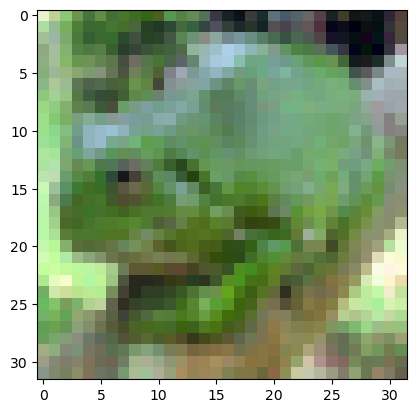

In [35]:
show_image(x_adv_PGD)

# 6. Evaluating the distance


Now, we will evaluate the distance between the original image and the adversarial images.

### Task 6
Implement the below formula:

$
\|v\|_p = \left( \sum_{i=1}^{n} |v_i|^p \right)^{\frac{1}{p}}.
$


Where v is the absolute difference between the input image and the adversarially perturbed image, complete the following function. This is equivalent to calculating the L_p norm.

Due to the addition of random noise, the distance for PGD will fluctuate above and below that of IGSM if they have the same parameters.

While numerical stability might render it impossible, the L_p norm should converge to the L_inf norm as p goes to infinity.

<details>
<summary>🔐 <b>Solution for Task #6</b></summary>

```python

def distance(x1, x2, p):
    """
    Return p norm of x1 and x2
    
    Parameters:
    -----------
    x1: Input tensor
    x2: Input tensor
    p: Norm integer
    
    Returns:
    --------
    distance: p norm of x1 and x2
    """
    return torch.sum(torch.abs(x1 -x2)**p) ** (1/p)
```

</details>

In [38]:
def distance(x1, x2, p):
    """
    Return p norm of x1 and x2
    
    Parameters:
    -----------
    x1: Input tensor
    x2: Input tensor
    p: Norm integer
    
    Returns:
    --------
    distance: p norm of x1 and x2
    """
    return ########## YOUR CODE ENDS HERE ########## 

In [39]:
_ = xlab.tests.section1_1.task6(distance)


Running tests for Section 2.4.2, Task 6...
🎉 All tests passed! (3/3)

Detailed output:
================================================= test session starts =================================================
collecting ... collected 3 items

..\xlab-python-package\xlab\tests\section1_1.py::TestTask6::test_l1_norm PASSED                                  [ 33%]
..\xlab-python-package\xlab\tests\section1_1.py::TestTask6::test_l2_norm PASSED                                  [ 66%]
..\xlab-python-package\xlab\tests\section1_1.py::TestTask6::test_multi_dimensional_tensor_summation PASSED       [100%]

================================================== 3 passed in 0.04s ==================================================



Below we calculate the $L_2$ norm for `x_adv_FGSM`, `x_adv_IGSM` and `x_adv_PGD`. This should see a value ~1.6 or ~1.7 for each attack we ran.

In [62]:
x = process_image('frog.jpg')
print(f"L2 Distance for FGSM: {distance(x, x_adv_FGSM, 2):.2f}")
print(f"L2 Distance for IGSM: {distance(x, x_adv_IGSM, 2):.2f}")
print(f"L2 Distance for PGD: {distance(x, x_adv_PGD, 2):.2f}")

L2 Distance for FGSM: 1.74
L2 Distance for IGSM: 1.65
L2 Distance for PGD: 1.65


Below we calculate the $L_{\infty}$ norm for `x_adv_FGSM`, `x_adv_IGSM` and `x_adv_PGD`. We don't use the distance function, but instead calculated it by hand, for reasons we will explain below.

If you did your attacks correctly, you should see a distance of ~0.0314.

In [64]:
l_inf_FGSM = torch.max(torch.abs(x_adv_FGSM - x)).item()
l_inf_IGSM = torch.max(torch.abs(x_adv_IGSM - x)).item()
l_inf_PGD = torch.max(torch.abs(x_adv_PGD - x)).item()

print(f"L infinity Distance for FGSM: {l_inf_FGSM:.4f}")
print(f"L infinity Distance for IGSM: {l_inf_IGSM:.4f}")
print(f"L infinity Distance for PGD: {l_inf_PGD:.4f}")

L infinity Distance for FGSM: 0.0314
L infinity Distance for IGSM: 0.0314
L infinity Distance for PGD: 0.0314


# 6a. Numerical Stability

Unfortunately, our implementation of the  approach `distance` function lacks numerical stability as p goes to infinity. To mitigate this, the distance function can be tweaked slightly to allow for a more precise calculation. 

For example, the below example goes to 0 instead of the L_inf norm of 0.0314.

In [66]:
print(distance(x, x_adv_IGSM, 100))

tensor(0.)


Here is more numerically stable version of the function. It divides the difference tensor by its maximimum value before raising it to the power of p, before multiplying it back again, leading to greater robustness. Intuitively, this is because it makes every value lower than one, so there is no explosion with increasing powers.

In [68]:
def distance(x1, x2, p):
    """
    Return p norm of x1 and x2
    
    Parameters:
    -----------
    x1: Input tensor
    x2: Input tensor
    p: Norm integer
    
    Returns:
    --------
    distance: p norm of x1 and x2
    """
    z = torch.max(abs(x1 - x2))
    x = (torch.abs(x1 - x2) / z) ** p
    x = torch.sum(x)
    return z * x ** (1/p)

The below demonstration shows how the L_norm of x and PGD converges to L_inf as p goes to infinity.

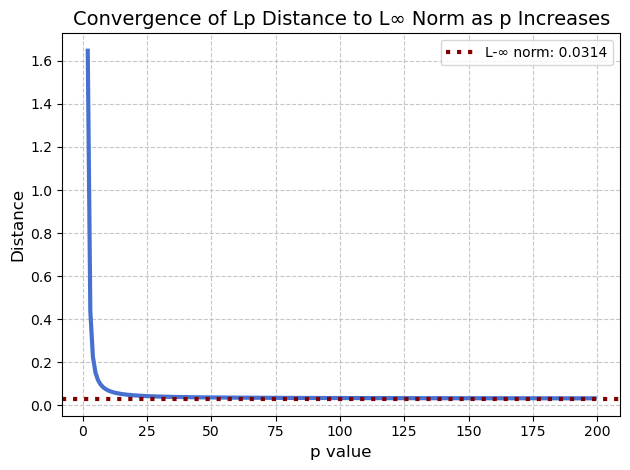

In [70]:
l_inf_norm = torch.max(torch.abs(x - x_adv_PGD)).item()
p_values = range(2,200)  
distances = [distance(x, x_adv_PGD, p).item() for p in p_values]

plt.plot(p_values, distances, '#4871cf', linewidth=3, markersize=6)
plt.axhline(y=l_inf_norm, color='maroon', linestyle='dotted', linewidth=3, label=f'L-∞ norm: {l_inf_norm:.4f}')
# plt.yscale('log')  # Log scale for y-axis
plt.xlabel('p value', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.title('Convergence of Lp Distance to L∞ Norm as p Increases', fontsize=14)
plt.grid(True, ls="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()